In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import gymnasium as gym

In [4]:
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3 import A2C

2023-06-13 06:40:37.654031: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 06:40:37.687691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 06:40:38.209357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
from stable_baselines3.common.evaluation import evaluate_policy

In [6]:
env_id = "CartPole-v1"
# The different number of processes that will be used
PROCESSES_TO_TEST = 20
NUM_EXPERIMENTS = 5  # RL algorithms can often be unstable, so we run several experiments (see https://arxiv.org/abs/1709.06560)
TRAIN_STEPS = 1E4
# Number of episodes for evaluation
ALGO = A2C

In [7]:
from stable_baselines3.common.env_util import make_vec_env

In [8]:
# Create log dir
log_dir_root = "./logging/cartpole"
os.makedirs(log_dir_root, exist_ok=True)

In [9]:
for experiment in range(NUM_EXPERIMENTS):
    # it is recommended to run several experiments due to variability in results
    log_dir = f"{log_dir_root}/run_{experiment}"
    train_env = make_vec_env(env_id, 
                         n_envs=PROCESSES_TO_TEST,
                         monitor_dir=log_dir)
    train_env.reset()
    model = ALGO("MlpPolicy", train_env, verbose=0)
    model.learn(total_timesteps=TRAIN_STEPS)

In [10]:
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [11]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")

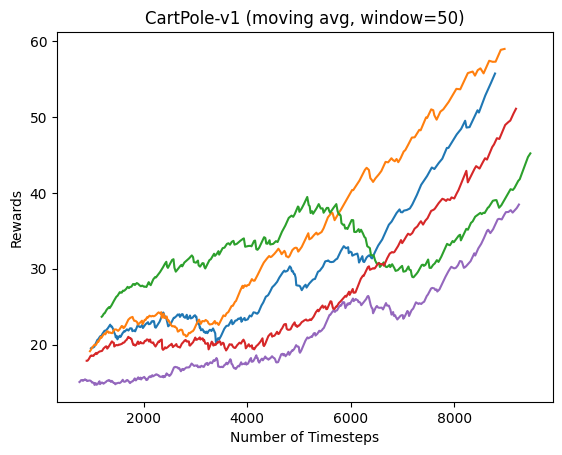

In [12]:
fig = plt.figure()
plt.xlabel("Number of Timesteps")
plt.ylabel("Rewards")
title = env_id
plt.title(title + " (moving avg, window=50)")
for experiment in range(NUM_EXPERIMENTS):
    log_dir = f"{log_dir_root}/run_{experiment}"
    x, y = ts2xy(load_results(log_dir), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]    
    plt.plot(x, y)  
plt.show()    

In [13]:
y_all = []
x_all = np.arange(TRAIN_STEPS)
for experiment in range(NUM_EXPERIMENTS):
    log_dir = f"{log_dir_root}/run_{experiment}"
    x, y = ts2xy(load_results(log_dir), "timesteps")
    '''
    x = timestep when reward y is received. For cartpole, this is 
    only at end of episode
    Since different runs receive rewards at different timesteps, we 
    need to "interpolate" the rewards so as to find the average across all runs
    '''
    yinterp = np.interp(x_all, x, y)
    y_all.append(yinterp)
yall = np.array(y_all)

In [14]:
yall_smooth = []
for i in range(yall.shape[0]):
    moving_avg = moving_average(yall[i,:], window=50)
    yall_smooth.append(moving_avg)
yall_smooth = np.array(yall_smooth)

In [15]:
yall_mean = np.mean(yall_smooth, axis=0)
yall_max = np.max(yall_smooth, axis=0)
yall_min = np.min(yall_smooth, axis=0)
yall_std = np.std(yall_smooth, axis=0)

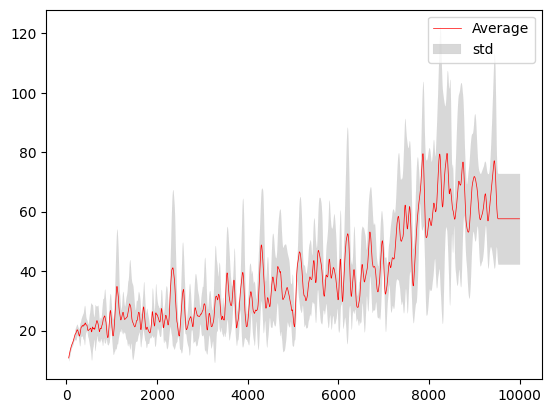

In [16]:
# Plotting
fig = plt.figure()
# Truncate x
x_all_smooth = x_all[len(x_all) - len(yall_smooth[0]):]
# plt.plot(x_all, yall_mean, 'bo', alpha=0.3)  # Scatter plot of all data points
plt.plot(x_all_smooth, yall_mean, 
         'r-', 
         label='Average',
        linewidth=0.5)  # Average line

plt.fill_between(x_all_smooth,
                 # yall_min, yall_max,
                 yall_mean-yall_std, yall_mean+yall_std, 
                 color='gray', 
                 alpha=0.3, 
                 label='std',
                linewidth=0.05)  # Shaded standard deviation
plt.legend()
plt.show()